In [49]:
#Importing Necessary Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import re
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [50]:
train_df = pd.read_csv('/kaggle/input/twittersentimentdata/train.csv')
test_df = pd.read_csv('/kaggle/input/twittersentimentdata/test.csv')

In [51]:
train_df.shape

(31962, 3)

In [52]:
train_df.duplicated().sum()

0

In [53]:
train_df.dtypes

id        int64
label     int64
tweet    object
dtype: object

In [54]:
train_df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [55]:
test_df.isnull().sum()

id       0
tweet    0
dtype: int64

In [56]:
# Plotting Word Clouds
stopwords = set(STOPWORDS)
stopwords.add('user')

def plot_wordcloud(tweets, title):
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate(tweets)
    plt.figure(figsize=(14, 6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, fontdict={'fontsize': 20})
    plt.show()

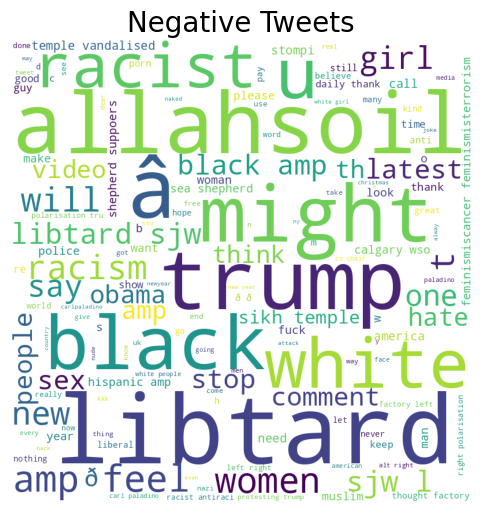

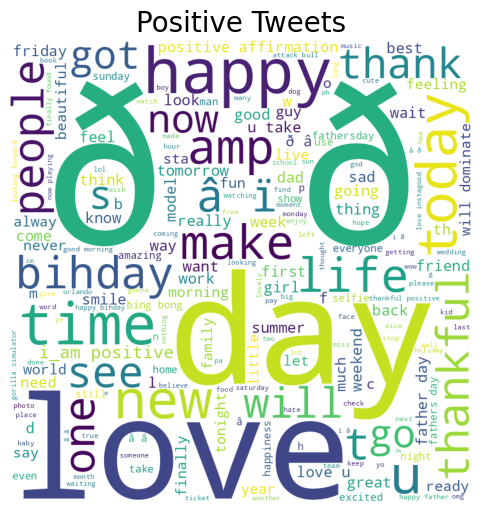

In [57]:
negative_tweets = train_df['tweet'][train_df['label'] == 1].to_string()
positive_tweets = train_df['tweet'][train_df['label'] == 0].to_string()

plot_wordcloud(negative_tweets, 'Negative Tweets')
plot_wordcloud(positive_tweets, 'Positive Tweets')

# Feature Engineering

In [58]:
# Feature Engineering
train_df_fe = train_df.copy()
train_df_fe['tweet_length'] = train_df_fe['tweet'].str.len()
train_df_fe['num_hashtags'] = train_df_fe['tweet'].str.count('#')
train_df_fe['num_exclamation_marks'] = train_df_fe['tweet'].str.count('!')
train_df_fe['num_question_marks'] = train_df_fe['tweet'].str.count('\?')
train_df_fe['total_tags'] = train_df_fe['tweet'].str.count('@')
train_df_fe['num_punctuations'] = train_df_fe['tweet'].str.count('[.,:;]')
train_df_fe['num_words'] = train_df_fe['tweet'].apply(lambda x: len(x.split()))
train_df_fe.head()

,id,label,tweet,tweet_length,num_hashtags,num_exclamation_marks,num_question_marks,total_tags,num_punctuations,num_words
0,1,0,@user when a father is dysfunctional and is s...,102,1,0,0,1,1,18
1,2,0,@user @user thanks for #lyft credit i can't us...,122,3,0,0,2,1,19
2,3,0,bihday your majesty,21,0,0,0,0,0,3
3,4,0,#model i love u take with u all the time in ...,86,1,3,0,0,0,14
4,5,0,factsguide: society now #motivation,39,1,0,0,0,1,4


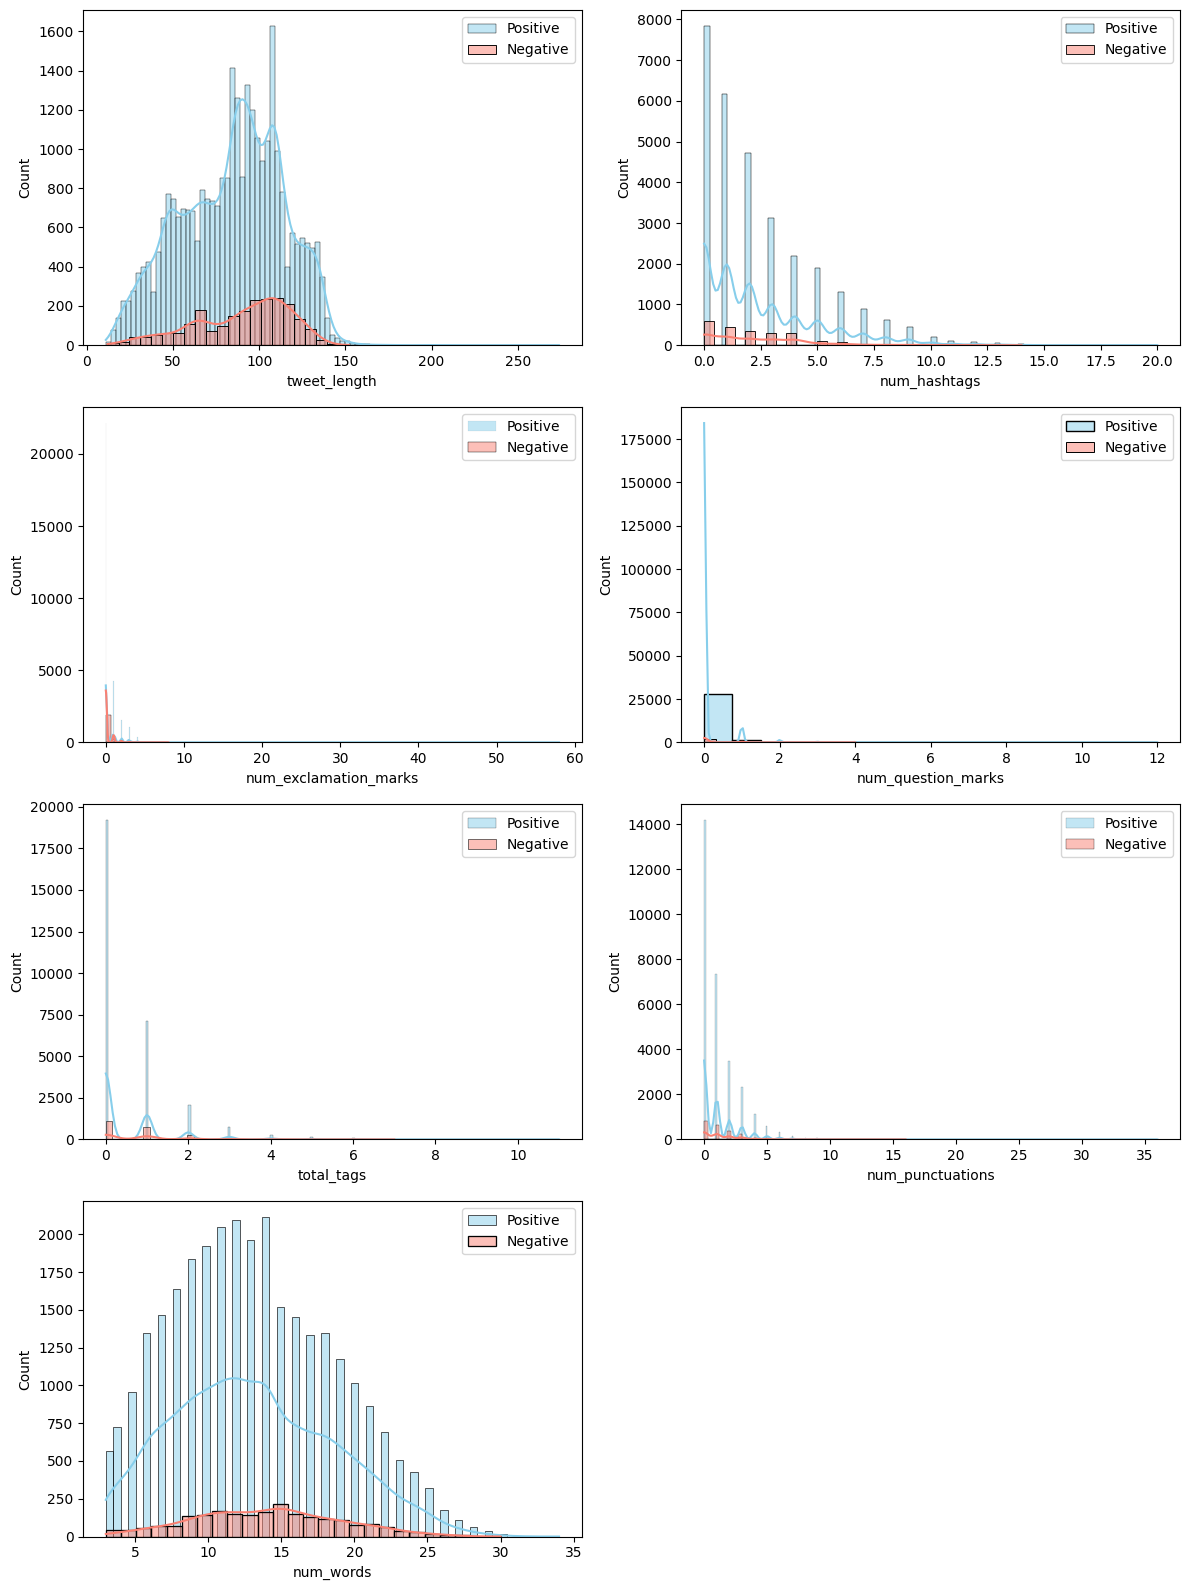

In [59]:
# Visualizing Relationship of Engineered Features with Sentiments
features = ['tweet_length', 'num_hashtags', 'num_exclamation_marks', 'num_question_marks', 'total_tags', 'num_punctuations', 'num_words']

# Check if train_df_fe has the expected columns
if set(features).issubset(train_df_fe.columns):
    plt.figure(figsize=(12, 16))
    colors = ['skyblue', 'salmon']  

    for i, feature in enumerate(features, 1):
        plt.subplot(4, 2, i)
        sns.histplot(train_df_fe[train_df_fe.label == 0][feature], label='Positive', kde=True, color=colors[0])
        sns.histplot(train_df_fe[train_df_fe.label == 1][feature], label='Negative', kde=True, color=colors[1])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Data Preprocessing

In [60]:
# Data Preprocessing
X = train_df.drop(columns=['label'])
y = train_df['label']
test = test_df

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Text Normalization

In [62]:
def tokenize_and_clean(text):
    lowered = text.lower()
    cleaned = re.sub('@user', '', lowered)
    tokens = word_tokenize(cleaned)
    filtered_tokens = [token for token in tokens if re.match(r'\w{1,}', token)]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(token) for token in filtered_tokens]
    return stems

## Vectorization

In [63]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_and_clean, stop_words='english')
X_train_tweets_tfidf = tfidf_vectorizer.fit_transform(X_train['tweet'])
X_test_tweets_tfidf = tfidf_vectorizer.transform(X_test['tweet'])
X_tweets_tfidf = tfidf_vectorizer.fit_transform(X['tweet'])
test_tweets_tfidf = tfidf_vectorizer.transform(test['tweet'])

## SMOTE

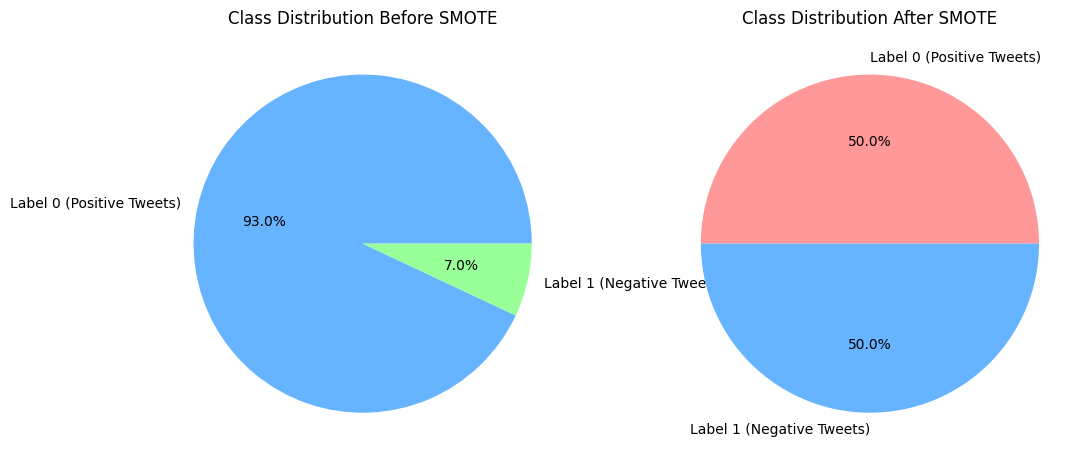

In [64]:
# Class Imbalance Check Before SMOTE
plt.figure(figsize=(12, 6))

# Colors for the pie charts
colors_before_smote = ['#66b3ff', '#99ff99']
colors_after_smote = ['#ff9999', '#66b3ff']

labels = ['Label 0 (Positive Tweets)', 'Label 1 (Negative Tweets)']

# Plotting before SMOTE
plt.subplot(1, 2, 1)
plt.pie(y_train.value_counts(), labels=labels, autopct='%0.1f%%', colors=colors_before_smote)
plt.title('Class Distribution Before SMOTE')

# SMOTE to deal with the class imbalance
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_tweets_tfidf, y_train.values)

# Plotting after SMOTE
plt.subplot(1, 2, 2)
plt.pie(pd.value_counts(y_train_smote), labels=labels, autopct='%0.1f%%', colors=colors_after_smote)
plt.title('Class Distribution After SMOTE')
plt.show()

# ML Model

In [65]:
# Functions to print scores
def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Training Scores: Accuracy={acc}, F1-Score={f1}')

def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Validation Scores: Accuracy={acc}, F1-Score={f1}')

In [66]:
# Machine Learning Modeling
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    training_scores(y_train, y_train_pred)
    validation_scores(y_test, y_test_pred)

In [67]:
# Logistic Regression
lr = LogisticRegression()
train_and_evaluate(lr, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=0.974, F1-Score=0.975
Validation Scores: Accuracy=0.924, F1-Score=0.601


In [68]:
# Naive Bayes Classifier
mnb = MultinomialNB()
train_and_evaluate(mnb, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=0.966, F1-Score=0.967
Validation Scores: Accuracy=0.921, F1-Score=0.609


In [69]:
# Random Forest Classifier
rf = RandomForestClassifier()
train_and_evaluate(rf, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=1.0, F1-Score=1.0
Validation Scores: Accuracy=0.955, F1-Score=0.648


In [70]:
# Extreme Gradient Boosting Classifier
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
train_and_evaluate(xgb, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=0.941, F1-Score=0.938
Validation Scores: Accuracy=0.942, F1-Score=0.597


# Hyperparameter Tuning

In [71]:
rf_tuned = RandomForestClassifier(criterion='entropy',
                                  max_samples=0.8, 
                                  min_samples_split=10, 
                                  random_state=0)
train_and_evaluate(rf_tuned, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=0.999, F1-Score=0.999
Validation Scores: Accuracy=0.957, F1-Score=0.682


In [72]:
xgb_tuned = XGBClassifier(objective='binary:logistic',
                          eval_metric='logloss',
                          learning_rate=0.8,
                          max_depth=20,
                          gamma=0.6,
                          reg_lambda=0.1,
                          reg_alpha=0.1)
train_and_evaluate(xgb_tuned, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=0.998, F1-Score=0.998
Validation Scores: Accuracy=0.954, F1-Score=0.65


Your support with an **upvote** would be greatly valued.